In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import bqplot as bq
import ipywidgets as widgets
import numpy as np
import requests
import os
import seaborn as sns


# Creating buttons for downloading and refreshing plots
download_button = widgets.Button(description="Download Dataset")
refresh_button = widgets.Button(description="Refresh Plots")


In [2]:
# Working on requesting and saving data from APi

def fetch_and_save_data(_):
    api_url = "https://api.open-meteo.com/v1/forecast?latitude=41.88&longitude=-87.63&hourly=temperature_2m,relative_humidity_2m,precipitation,cloudcover,windspeed_10m&timezone=auto"
    
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        data = response.json()  # we need to Parse JSON
        
        # and then transform to csv
        hourly = data['hourly']
        df = pd.DataFrame(hourly)
        df.to_csv("chicago_weather_data.csv", index=False)
        print("Weather data Refreshed and downloaded")
        
    except Exception as e:
        pass
    
def refresh_plots(_):
    try:
        # Read from the saved CSV file
        df_raw = pd.read_csv("chicago_weather_data.csv")
        
        # Convert to proper types
        df_raw['time'] = pd.to_datetime(df_raw['time'], errors='coerce')
        for col in ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloudcover', 'windspeed_10m']:
            df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
        
        # Assign to global variable so that we can use it else where in the notebook
        global df
        df = df_raw

        print("Plots refreshed")
        
    except Exception as e:
        pass

    



In [10]:
#Let us download and refresh the data before starting the plots.
fetch_and_save_data(None)
refresh_plots(None)


Weather data Refreshed and downloaded
Plots refreshed


In [4]:
#This can be also done by clicking the buttons below.
print('The data and visuals has already been refreshed, but adding buttons for clarity')
download_button.on_click(fetch_and_save_data)
refresh_button.on_click(refresh_plots)
widgets.HBox([download_button, refresh_button])


The data and visuals has already been refreshed, but adding buttons for clarity


In [5]:
#Plot3


variable_labels = {
    'temperature_2m': 'Temperature',
    'relative_humidity_2m': 'Humidity',
    'precipitation': 'Precipitation',
    'cloudcover': 'Cloud Cover'
}

dropdown = widgets.Dropdown(
    options=[(label, key) for key, label in variable_labels.items()],
    value='temperature_2m',
    description='Select Variable:',
    style={'description_width': 'initial'}
)

x_sc = bq.DateScale()
y_sc = bq.LinearScale()

line = bq.Lines(
    x=df['time'],
    y=df['temperature_2m'],
    scales={'x': x_sc, 'y': y_sc},
    display_legend=False,
    stroke_width=2
)


x_ax = bq.Axis(label='Time', scale=x_sc)
y_ax = bq.Axis(label='Value', scale=y_sc, orientation='vertical')


fig = bq.Figure(
    title='Chicago Temperature Over Time',
    marks=[line],
    axes=[x_ax, y_ax],
    legend_location='top-left'
)


def update_plot(change):
    var = dropdown.value
    line.y = df[var]
    line.x = df['time']
    fig.title = f"{variable_labels[var]} Over Time"

dropdown.observe(update_plot, names='value')

# Show widgets
widgets.VBox([dropdown, fig])


This interactive line chart displays weather trends in Chicago over time. Users can dynamically switch between variables—Temperature, Humidity, Precipitation, and Cloud Cover—using the dropdown menu. The x-axis represents time, while the y-axis shows the corresponding value of the selected variable.

This tool allows for quick comparison of different weather factors and can help identify short-term trends and patterns in local atmospheric conditions.

Note: If the precipitation value is 0, it basically says chaces of rain are very low.

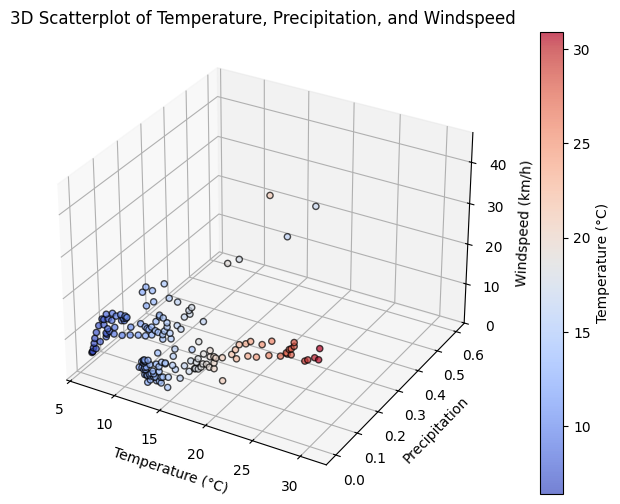

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming DataFrame is named 'df'
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(df['temperature_2m'], df['precipitation'], df['windspeed_10m'],
                    c=df['temperature_2m'], cmap='coolwarm', s=20, marker='o', alpha=0.7, edgecolors='black')

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Precipitation')
ax.set_zlabel('Windspeed (km/h)')
plt.title('3D Scatterplot of Temperature, Precipitation, and Windspeed')


cbar = plt.colorbar(scatter, ax=ax, label='Temperature (°C)')

plt.show()

# 3D Visualization of Forecasted Temperature, Precipitation, and Windspeed in Chicago
The 3D scatterplot above offers a multidimensional representation of forecasted hourly weather data for Chicago, bringing together three key atmospheric variables: temperature (°C), precipitation (mm), and windspeed (km/h). Each data point in the plot corresponds to an individual hour within the forecast period.

The X-axis indicates the air temperature measured in degrees Celsius. This variable is also used to color-code the data points, with a gradient transitioning from cool blues (lower temperatures) to warm reds (higher temperatures).
The Y-axis represents the precipitation values in millimeters. This axis helps track moisture levels and potential rainfall accumulation.
The Z-axis captures the windspeed in kilometers per hour, a vital component of local weather that can influence conditions like wind chill or the spread of precipitation.
A color bar on the right reinforces the temperature scale applied to each point, enhancing visual readability and temperature-based clustering.
The plot will let users observe whether higher temperatures are associated with calmer or stronger winds, or identify clusters of data where precipitation levels peak.

In [7]:
df.head()

,time,temperature_2m,relative_humidity_2m,precipitation,cloudcover,windspeed_10m
0,2025-05-13 00:00:00,15.0,85,0.1,95,7.7
1,2025-05-13 01:00:00,14.6,85,0.0,11,8.9
2,2025-05-13 02:00:00,14.2,86,0.0,31,9.0
3,2025-05-13 03:00:00,14.1,86,0.0,11,5.2
4,2025-05-13 04:00:00,14.1,87,0.0,7,3.8


In [8]:

#Making sure the the format is correct. I might have done it before but I like to make sure of it.
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['temperature_2m'] = pd.to_numeric(df['temperature_2m'], errors='coerce')

# we will extract date only and then group by 
df['date_only'] = df['time'].dt.date

grouped = df.groupby('date_only')['temperature_2m'].agg(['min', 'mean', 'max']).reset_index()

slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grouped) - 1,
    step=1,
    description='Day Index:',
    continuous_update=False
)

x_scale = bq.OrdinalScale()
y_scale = bq.LinearScale()

bar = bq.Bars(
    x=['Min', 'Mean', 'Max'],
    y=grouped.iloc[slider.value, 1:].tolist(),
    scales={'x': x_scale, 'y': y_scale},
    colors=['#76b5c5'],
)

x_axis = bq.Axis(scale=x_scale, label='Temperature Summary')
y_axis = bq.Axis(scale=y_scale, orientation='vertical', label='Temperature (°C)')

fig = bq.Figure(
    marks=[bar],
    axes=[x_axis, y_axis],
    title=f"Temperature Summary for {grouped['date_only'].iloc[slider.value]}"
)

def update_bar(change):
    i = slider.value
    bar.y = grouped.iloc[i, 1:].tolist()
    fig.title = f"Temperature Summary for {grouped['date_only'].iloc[i]}"

slider.observe(update_bar, names='value')

widgets.VBox([slider, fig])


This interactive bar chart presents a temperature summary for a selected day based on hourly weather forecast data. It displays three key metrics for that day:

Minimum temperature
Average (mean) temperature
Maximum temperature
All values are shown in degrees Celsius (°C), providing a concise yet informative snapshot of how temperatures fluctuate throughout the day.

The user can adjust the day using the slider above the chart. As the slider value changes, the chart dynamically updates to reflect the corresponding temperature statistics for the newly selected day. This allows for quick comparisons across different dates and helps identify patterns such as warming or cooling trends over the forecast period.

This visualization is particularly useful for identifying temperature ranges and daily variability, making it ideal for planning activities or analyzing weather patterns in a user-friendly format.

/tmp/ipykernel_174/1696330773.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='date_only', y='windspeed_10m', palette='Set3')


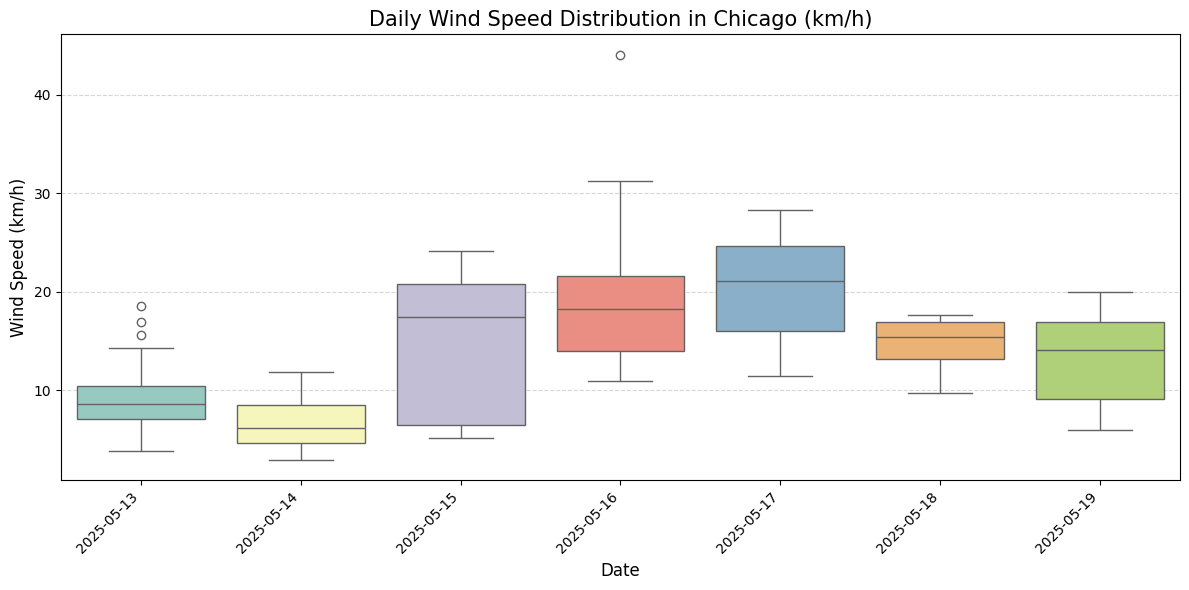

In [9]:


def plot_wind_boxplot(df):
    df['date_only'] = df['time'].dt.date

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='date_only', y='windspeed_10m', palette='Set3')

    plt.title('Daily Wind Speed Distribution in Chicago (km/h)', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Wind Speed (km/h)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_wind_boxplot(df)


# Daily Wind Speed Distribution in Chicago (km/h)
This box plot represents the forecasted distribution of hourly wind speeds in Chicago over a one-week period. Each box corresponds to a specific date and summarizes the variability and range of wind speeds expected on that day.

### 📊 How to interpret the plot:

#### Boxes (Interquartile Range - IQR): Each box captures the middle 50% of wind speed values for the day — from the 25th percentile (Q1) to the 75th percentile (Q3). This shows the core range of expected wind speeds.
#### Horizontal line within each box: Indicates the median wind speed, offering a measure of central tendency for that day.
#### Whiskers: Extend to the most extreme data points within 1.5 times the IQR from Q1 and Q3. These represent the range of typical wind speeds, excluding extreme outliers.
#### Individual points beyond whiskers: Plotted as outliers, these represent potential instances of unusually low or high wind speeds.
#### Color coding: Different colors are used to distinguish each day's distribution visually and enhance readability.
#### 🌆 Contextual Note:

Given that Chicago is popularly known as the “Windy City,” analyzing wind speed patterns is both relevant and practical. This type of visualization helps users anticipate variability and understand daily wind dynamics at a glance — crucial for sectors like aviation, infrastructure, logistics, and public planning.

The plot provides a compact summary of variability across multiple days, making it ideal for comparing trends, assessing forecast consistency, and communicating expectations effectively.